<a href="https://colab.research.google.com/github/FabioMMaia/Word2vec_Visualization/blob/main/Word2vec_Port.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import multiprocessing

from gensim.models import Word2Vec

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Projeto ML/2023/Word2vec/simpsons_dataset.csv')
df.shape

(158314, 2)

In [4]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [100]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [101]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [102]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

In [103]:
# nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [104]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [105]:
?nlp.pipe

In [106]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.68 mins


In [107]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85954, 1)

In [108]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]


In [109]:
phrases = Phrases(sent, min_count=30, progress_per=10000)


In [110]:
bigram = Phraser(phrases)

In [111]:
bigram['I','know','you']

['I', 'know', 'you']

In [112]:
bigram['I','want', 'to', 'go', 'to','you']

['I', 'want', 'to', 'go_to', 'you']

In [113]:
sentences = bigram[sent]

In [ ]:
for sent in sentences[:80]:
  print(sent)

['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think']
['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach']
['life', 'worth', 'live']
['poll', 'open', 'end', 'recess', 'case', 'decide', 'thought', 'final', 'statement', 'martin']
['victory', 'party', 'slide']
['mr', 'bergstrom', 'mr', 'bergstrom']
['hey', 'hey', 'move', 'morning', 'new', 'job', 'take', 'copernicus', 'costume']
['think', 'take', 'train', 'capital_city']
['train', 'like', 'traditional', 'environmentally', 'sound']
['yes', 'backbone', 'country', 'leland', 'stanford', 'drive', 'golden', 'spike', 'promontory', 'point']
['hey', 'thank', 'vote', 'man']
['vote', 'voting', 'geek']
['get', 'right', 'thank', 'vote', 'girl']
['sweat', 'long', 'couple', 'people', 'right', 'milhouse']
['martin', 'martin', 'like', 'recount']
['want', 'sure', 'martin', 'martin']
['way', 'mister', 'president']
['board', 'track', 'afternoon', 'delight', 'come', 'shelbyville', 'parkville']
['mr', 'bergstrom', 'he

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29674

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

# Treinando o Modelo

In [13]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.9 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.8027812242507935),
 ('gee', 0.7910184860229492),
 ('sweetheart', 0.7868350148200989),
 ('depressed', 0.7574946880340576),
 ('creepy', 0.755972683429718),
 ('bongo', 0.7447065711021423),
 ('hammock', 0.7444443702697754),
 ('snuggle', 0.7425099611282349),
 ('crummy', 0.7382405996322632),
 ('sure', 0.7358872294425964)]

In [ ]:
w2v_model.wv.most_similar(positive=["student"])

[('elementary', 0.9008631706237793),
 ('assembly', 0.8452527523040771),
 ('graduate', 0.8421666622161865),
 ('detention', 0.8290125131607056),
 ('springfield_elementary', 0.8201214671134949),
 ('lounge', 0.8123481273651123),
 ('class', 0.7961565256118774),
 ('mrs_krabappel', 0.7961558103561401),
 ('lisa_simpson', 0.7946910858154297),
 ('education', 0.7944000959396362)]

In [ ]:
w2v_model.wv.most_similar(positive=["crazy"])

[('crummy', 0.7375006675720215),
 ('annoying', 0.7186061143875122),
 ('pretty', 0.7181580066680908),
 ('bongo', 0.7161078453063965),
 ('becky', 0.7079020738601685),
 ('shoulda', 0.7009493112564087),
 ('hopeless', 0.6931554675102234),
 ('doll', 0.6917977333068848),
 ('vegas', 0.6803334951400757),
 ('pretend', 0.679641842842102)]

In [ ]:
w2v_model.wv.most_similar(positive=["beer"])

[('duff', 0.8720695376396179),
 ('drink', 0.7899038791656494),
 ('blimp', 0.7857292890548706),
 ('champagne', 0.7763576507568359),
 ('duffman', 0.736282467842102),
 ('bartender', 0.7212621569633484),
 ('lemonade', 0.7209774255752563),
 ('mug', 0.7205972671508789),
 ('bottle', 0.7038781642913818),
 ('grab', 0.6869010329246521)]

In [ ]:
w2v_model.wv.most_similar(positive=["beer"])

[('duff', 0.8720695376396179),
 ('drink', 0.7899038791656494),
 ('blimp', 0.7857292890548706),
 ('champagne', 0.7763576507568359),
 ('duffman', 0.736282467842102),
 ('bartender', 0.7212621569633484),
 ('lemonade', 0.7209774255752563),
 ('mug', 0.7205972671508789),
 ('bottle', 0.7038781642913818),
 ('grab', 0.6869010329246521)]

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    # print(arrays.shape)
    # reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


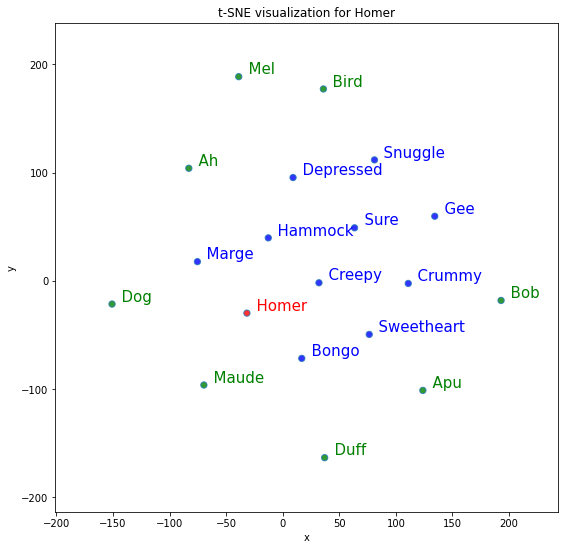

In [ ]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

In [122]:
words = list(w2v_model.wv.vocab.keys())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


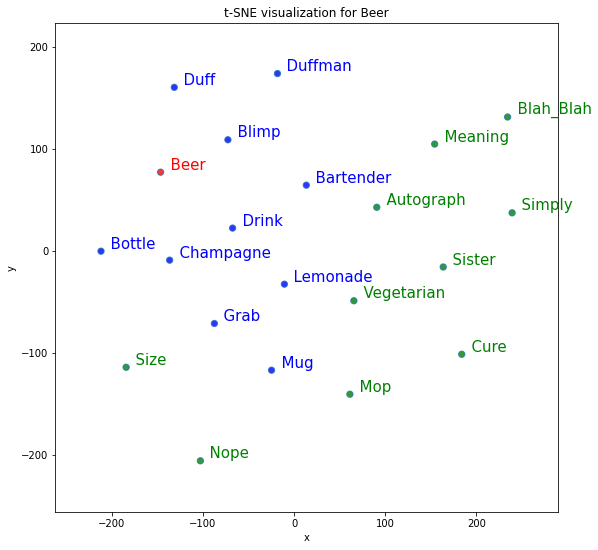

In [ ]:
tsnescatterplot(w2v_model, 'beer', random.choices(words, k=10))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


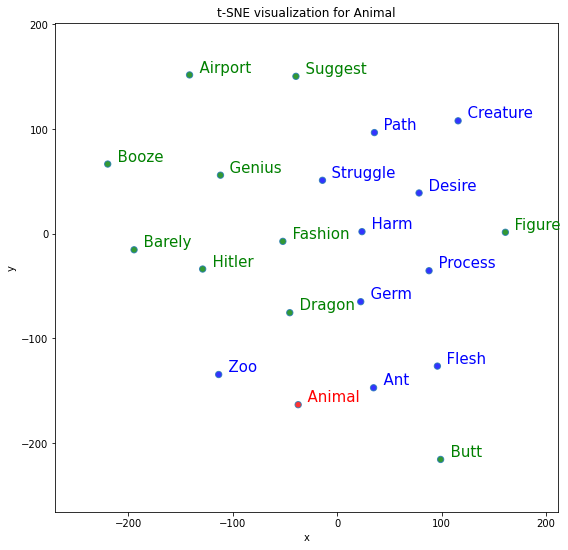

In [ ]:
tsnescatterplot(w2v_model, 'animal', random.choices(words, k=10))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


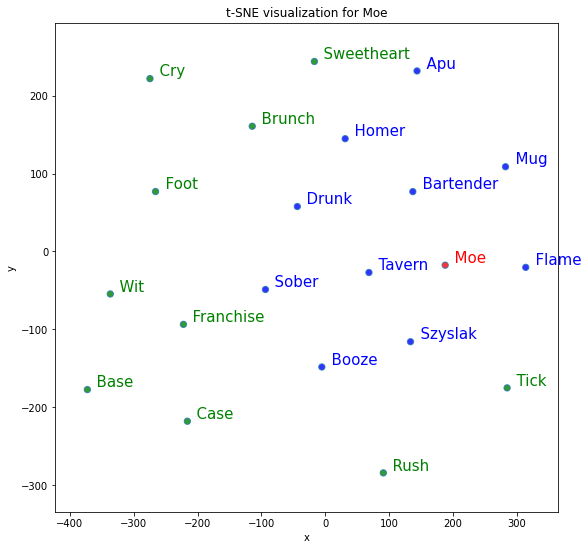

In [ ]:
tsnescatterplot(w2v_model, 'moe', random.choices(words, k=10))

# Continuação do Treino

In [35]:
import gensim.downloader


In [36]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [37]:
word2vec_news = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [8]:
path_save_model = '/content/drive/MyDrive/Projeto ML/2023/Word2vec'
import os
import pickle

# with open(os.path.join(path_save_model, 'word2vec_new.obj'), 'wb') as fp:
#   pickle.dump(word2vec_news, fp)

# word2vec_news.save(os.path.join(path_save_model, 'model_news.model'))

In [9]:
# import pickle
# import os

# with open(os.path.join(path_save_model, 'model_news.model'), "rb") as f:
#     word2vec_news = pickle.load(f)

In [11]:
import gensim
gensim.__version__

'3.6.0'

In [38]:
word2vec_news

In [89]:
w2v_model = Word2Vec(min_count=1,
                     size=300,
                     workers=cores-1)

In [80]:
word2vec_news.vocab['in']

In [90]:
all_words= list(word2vec_news.vocab.keys())

In [91]:
all_words[0]

'</s>'

In [92]:
w2v_model.build_vocab([all_words])

In [94]:
w2v_model.wv.vectors = word2vec_news.vectors

In [97]:
word2vec_news['water'][:20]

array([-0.15136719,  0.13671875,  0.11669922, -0.17871094, -0.11181641,
        0.00744629, -0.00262451, -0.20605469,  0.00927734,  0.09960938,
        0.04223633, -0.08251953, -0.05688477, -0.01525879, -0.19726562,
       -0.0062561 , -0.04907227,  0.01300049,  0.00759888,  0.125     ],
      dtype=float32)

In [98]:
w2v_model.wv['water'][:20]

array([-0.15136719,  0.13671875,  0.11669922, -0.17871094, -0.11181641,
        0.00744629, -0.00262451, -0.20605469,  0.00927734,  0.09960938,
        0.04223633, -0.08251953, -0.05688477, -0.01525879, -0.19726562,
       -0.0062561 , -0.04907227,  0.01300049,  0.00759888,  0.125     ],
      dtype=float32)

In [93]:
list(w2v_model.wv.vocab.keys())[:30]

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 '####',
 'his',
 'an',
 'this',
 'or']

In [75]:
list(word2vec_news.vocab.keys())[:30]

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 '####',
 'his',
 'an',
 'this',
 'or']

In [70]:
w2v_model.wv.vocab

{}

In [61]:
# w2v_model.build_vocab(list(word2vec_news.vocab.keys()))

In [114]:
w2v_model.build_vocab(sentences, update=True)

In [ ]:
tsnescatterplot(w2v_model, 'homer', random.choices(words, k=10))

In [119]:
word2vec_news['duffman'][:20]

KeyError: ignored

In [120]:
w2v_model.wv['duffman'][:20]

array([-5.7801843e-04,  1.0640486e-03, -2.6247840e-04,  1.1960084e-03,
        1.2552910e-03, -2.2583442e-04,  8.7797531e-04,  4.3949732e-04,
        3.2649451e-04,  1.1773936e-03,  1.3921392e-03, -1.6092169e-03,
        5.7063735e-04,  1.0810982e-03,  6.2429457e-04,  2.9259945e-05,
        9.4825076e-04, -1.1172171e-03,  9.3679805e-04, -2.6226556e-04],
      dtype=float32)

In [62]:
# list(word2vec_news.vocab.keys())[0]

'</s>'

In [63]:
len(list(word2vec_news.vocab.keys()))

3000000

In [64]:
len(list(w2v_model.wv.vocab.keys()))

1319

In [46]:
word2vec_news['banana'][:5]

array([-0.08544922,  0.04711914, -0.06933594,  0.30273438, -0.1875    ],
      dtype=float32)

In [48]:
w2v_model.wv['banana']

KeyError: ignored

In [39]:
word2vec_news.wv.most_similar(positive='banana')

<ipython-input-39-30d8cf85d4bb>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word2vec_news.wv.most_similar(positive='banana')


[('bananas', 0.7523775696754456),
 ('pineapple', 0.6587538123130798),
 ('mango', 0.6365211606025696),
 ('pineapples', 0.6313878297805786),
 ('papaya', 0.6063666343688965),
 ('coconut', 0.6035483479499817),
 ('potato', 0.5747568607330322),
 ('melon', 0.5625776052474976),
 ('cashew', 0.562165379524231),
 ('tomato', 0.5590205788612366)]

<ipython-input-80-4c77a1b59a04>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  words_news = list(word2vec_news.wv.vocab.keys())
<ipython-input-40-e4c2efa110e1>:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
<ipython-input-40-e4c2efa110e1>:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  close_words = model.wv.most_similar([word])
<ipython-input-40-e4c2efa110e1>:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  wrd_vector = model.wv.__getitem__([wrd_score[0]])
<ipython-input-40-e4c2efa110e1>:31: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  wrd_vector = model.wv.__getitem__([wrd])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne

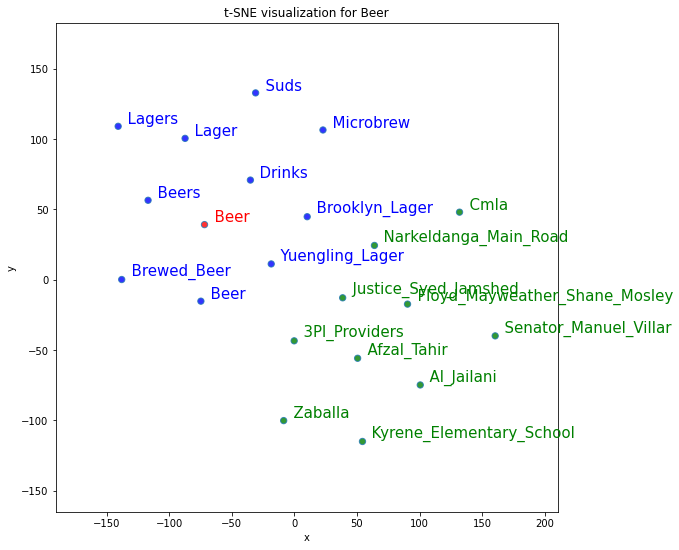

In [ ]:
words_news = list(word2vec_news.wv.vocab.keys())

tsnescatterplot(word2vec_news, 'beer', random.choices(words_news, k=10))

In [ ]:
word2vec_news.wv.most_similar(positive=["water"])

<ipython-input-81-99553d32ae64>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word2vec_news.wv.most_similar(positive=["water"])


[('potable_water', 0.6799106597900391),
 ('Water', 0.6706870794296265),
 ('sewage', 0.6619377136230469),
 ('groundwater', 0.6588345766067505),
 ('Floridan_aquifer', 0.6422533988952637),
 ('surficial_aquifer', 0.64188551902771),
 ('freshwater', 0.6307883262634277),
 ('potable', 0.6251926422119141),
 ('wastewater', 0.6212228536605835),
 ('brackish_groundwater', 0.6206730604171753)]

<ipython-input-40-e4c2efa110e1>:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
<ipython-input-40-e4c2efa110e1>:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  close_words = model.wv.most_similar([word])
<ipython-input-40-e4c2efa110e1>:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  wrd_vector = model.wv.__getitem__([wrd_score[0]])
<ipython-input-40-e4c2efa110e1>:31: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  wrd_vector = model.wv.__getitem__([wrd])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:7

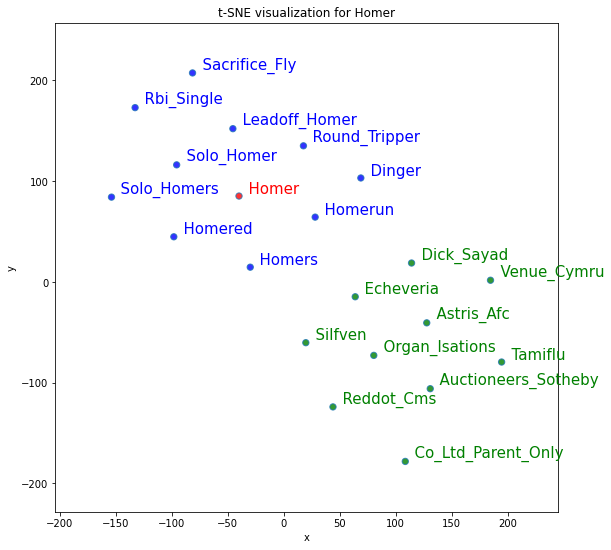

In [ ]:
tsnescatterplot(word2vec_news, 'homer', random.choices(words_news, k=10))

In [ ]:
# word2vec_news = gensim.models.Word2Vec.load(os.path.join(path_save_model, 'model_news.model'))

In [ ]:
from gensim.models import KeyedVectors
from gensim import models

# word2vec_path = 'path/GoogleNews-vectors-negative300.bin.gz'
# w2v_model = models.KeyedVectors.load_word2vec_format(os.path.join(path_save_model, 'model_news.model'), binary=False, encoding = 'latin-1')

ValueError: ignored

In [ ]:
word2vec_news.train(sentences, total_examples=len(sentences), epochs=word2vec_news.epochs)

AttributeError: ignored

In [ ]:
word2vec_news

In [ ]:
word2vec_news.build_vocab(sentences, progress_per=10000)

NameError: ignored

In [ ]:
word2vec_news.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

AttributeError: ignored

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec
import operator

os.mkdir("model_dir")

# class EpochSaver(CallbackAny2Vec):
#     '''Callback to save model after each epoch.'''
#     def __init__(self, path_prefix):
#         self.path_prefix = path_prefix
#         self.epoch = 0

#     def on_epoch_end(self, model):
#         list_of_existing_files = os.listdir(".")
#         output_path = 'model_dir/{}_epoch{}.model'.format(self.path_prefix, self.epoch)
#         try:
#             model.save(output_path)
#         except:
#             model.wv.save_word2vec_format('model_dir/model_{}.bin'.format(self.epoch), binary=True)
#         print("number of epochs completed = {}".format(self.epoch))
#         self.epoch += 1
#         list_of_total_files = os.listdir(".")

# saver = EpochSaver("my_finetuned")





# function to load vectors from existing model.
# I am loading glove vectors from a text file, benefit of doing this is that I get complete vocab of glove as well.
# If you are using a previous word2vec model I would recommed save that in txt format.
# In case you decide not to do it, you can tweak the function to get vectors for words in your vocab only.
def load_vectors(token2id, path,  limit=None):
    embed_shape = (len(token2id), 300)
    freqs = np.zeros((len(token2id)), dtype='f')

    vectors = np.zeros(embed_shape, dtype='f')
    i = 0
    with open(path, encoding="utf8", errors='ignore') as f:
        for o in f:
            token, *vector = o.split(' ')
            token = str.lower(token)
            if len(o) <= 100:
                continue
            if limit is not None and i > limit:
                break
            vectors[token2id[token]] = np.array(vector, 'f')
            i += 1

    return vectors


embedding_name = "glove.840B.300d.txt"
data = "<training data(new line separated tect file)>"

# Dictionary to store a unique id for each token in vocab( in my case vocab contains both my vocab and glove vocab)
token2id = {}

# This dictionary will contain all the words and their frequencies.
vocab_freq_dict = {}

# Populating vocab_freq_dict and token2id from my data.
id_ = 0
training_examples = []
file = open("{}".format(data),'r', encoding="utf-8")
for line in file.readlines():
    words = line.strip().split(" ")
    training_examples.append(words)
    for word in words:
        if word not in vocab_freq_dict:
            vocab_freq_dict.update({word:0})
        vocab_freq_dict[word] += 1
        if word not in token2id:
            token2id.update({word:id_})
            id_ += 1

# Populating vocab_freq_dict and token2id from glove vocab.
max_id = max(token2id.items(), key=operator.itemgetter(1))[0]
max_token_id = token2id[max_id]
with open(embedding_name, encoding="utf8", errors='ignore') as f:
    for o in f:
        token, *vector = o.split(' ')
        token = str.lower(token)
        if len(o) <= 100:
            continue
        if token not in token2id:
            max_token_id += 1
            token2id.update({token:max_token_id})
            vocab_freq_dict.update({token:1})

with open("vocab_freq_dict","wb") as vocab_file:
    pickle.dump(vocab_freq_dict, vocab_file)
with open("token2id", "wb") as token2id_file:
    pickle.dump(token2id, token2id_file)



# converting vectors to keyedvectors format for gensim
vectors = load_vectors(token2id, embedding_name)
vec = KeyedVectors(300)
vec.add(list(token2id.keys()), vectors, replace=True)

# setting vectors(numpy_array) to None to release memory
vectors = None

params = dict(min_count=1,workers=14,iter=6,size=300)

model = Word2Vec(**params)

# using build from vocab to build the vocab
model.build_vocab_from_freq(vocab_freq_dict)

# using token2id to create idxmap
idxmap = np.array([token2id[w] for w in model.wv.index2entity])

# Setting hidden weights(syn0 = between input layer and hidden layer) = your vectors arranged accoring to ids
model.wv.vectors[:] = vec.vectors[idxmap]

# Setting hidden weights(syn0 = between hidden layer and output layer) = your vectors arranged accoring to ids
model.trainables.syn1neg[:] = vec.vectors[idxmap]


model.train(training_examples, total_examples=len(training_examples), epochs=model.epochs)
output_path = 'model_dir/final_model.model'
model.save(output_path)
